In [1]:
import os
import config

from scipy import stats

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='darkgrid')

In [15]:
# Define necessary directory paths for reference text and scores, obtain the file count.

data_name = "movie_quotes"
data_path = "decode_" + data_name
log_name = os.path.join(config.log_root, data_path)

ref_dir = os.path.join(log_name, "rouge_ref")
dec_dir = os.path.join(log_name, "rouge_dec_dir")
scores_dir = os.path.join(log_name, "rouge_scores")

file_count = len(os.listdir(ref_dir))

In [3]:
# Obtain the score values for ROUGE1 from csv files.
df = pd.read_csv(os.path.join(scores_dir, 'rouge_1.csv'), usecols=['F1', 'Precision', 'Recall'])

In [21]:
# Get lengths from decaded and reference texts.
dec_lengths = []
ref_lengths = []
context_lengths = []
for i in range(len(os.listdir(ref_dir))):
    dec_file = os.path.join(dec_dir, str(i).zfill(6) + '_decoded.txt')
    ref_file = os.path.join(ref_dir, str(i).zfill(6) + '_reference.txt')

    with open(dec_file) as f:
        dec_lengths.append(len(f.read().split()))

    with open(ref_file) as f:
        ref_lengths.append(len(f.read().split()))

    context_dir = '../finished_files/'+data_name+'/input_tokenized_dir/index_'+str(i)+'.txt'
    with open(context_dir) as f:
        context_lengths.append(len(f.readline().split()))





df['dec_lengths'] = dec_lengths
df['ref_lengths'] = ref_lengths
df['context_lengths'] = context_lengths
df['summary_size'] = (df['context_lengths']-df['dec_lengths'])/df['context_lengths']
df

,F1,Recall,Precision,dec_lengths,ref_lengths,summary_size,context_lengths
0,0.421053,1.000000,0.266667,61,14,0.016129,62
1,0.720000,1.000000,0.562500,39,21,0.390625,64
2,0.181818,0.157895,0.214286,100,43,0.137931,116
3,0.968750,0.939394,1.000000,40,46,0.272727,55
4,0.682927,1.000000,0.518519,36,17,0.513514,74
...,...,...,...,...,...,...,...
1253,0.628571,1.000000,0.458333,37,11,0.531646,79
1254,0.088889,0.250000,0.054054,39,9,0.530120,83
1255,0.127660,0.300000,0.081081,45,13,0.224138,58
1256,0.711111,1.000000,0.551724,36,18,0.608696,92


In [27]:
# Remove outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [28]:
df.describe()

,F1,Recall,Precision,dec_lengths,ref_lengths,summary_size,context_lengths
count,1175.000000,1175.000000,1175.000000,1175.000000,1175.000000,1175.000000,1175.000000
mean,0.524306,0.743485,0.452642,41.257872,24.368511,0.626860,133.730213
std,0.277839,0.332602,0.294673,7.825550,19.565542,0.176930,60.935506
min,0.000000,0.000000,0.000000,35.000000,1.000000,0.000000,40.000000
25%,0.295875,0.451997,0.214286,36.000000,11.000000,0.540948,87.500000
50%,0.558140,1.000000,0.416667,38.000000,18.000000,0.657407,121.000000
75%,0.750000,1.000000,0.656250,43.000000,29.000000,0.759870,166.000000
max,1.000000,1.000000,1.000000,76.000000,122.000000,0.900285,359.000000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1175 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   F1               1175 non-null   float64
 1   Recall           1175 non-null   float64
 2   Precision        1175 non-null   float64
 3   dec_lengths      1175 non-null   int64  
 4   ref_lengths      1175 non-null   int64  
 5   summary_size     1175 non-null   float64
 6   context_lengths  1175 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 73.4 KB


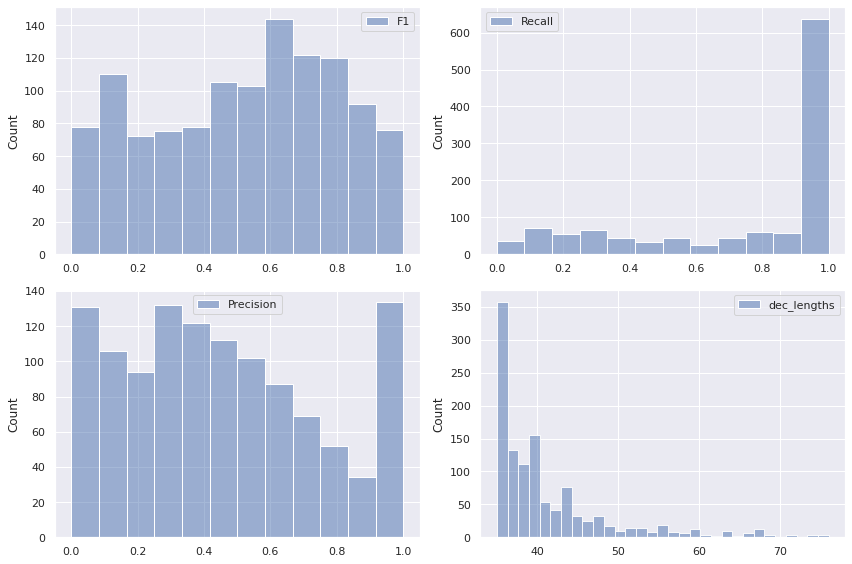

In [30]:
# Distributions of ROUGE scores and token length.

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
col=0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        sns.histplot(df.iloc[:, [col]], ax= ax[j, i])
        col+=1
fig.tight_layout()
fig.show()


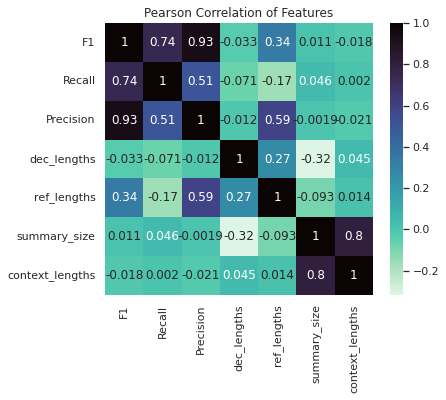

In [31]:
plt.figure(figsize=(6,5))
plt.title('Pearson Correlation of Features')
sns.heatmap(df.corr(), cmap = 'mako_r', annot = True)
plt.show()

In [32]:
# Sort by token_count

df = df.sort_values(by='summary_size', ascending=True).reset_index(drop=True)

In [33]:
# Smooth the values with exponential moving mean.

df['s_F1'] = df['F1'].ewm(com=500, adjust=True).mean()
df['s_Recall'] = df['Recall'].ewm(com=500, adjust=True).mean()
df['s_Precision'] = df['Precision'].ewm(com=500, adjust=True).mean()

<AxesSubplot:title={'center':'ROUGE Scores Over Decoded Text Length'}, xlabel='Decoded text length', ylabel='ROUGE Score'>

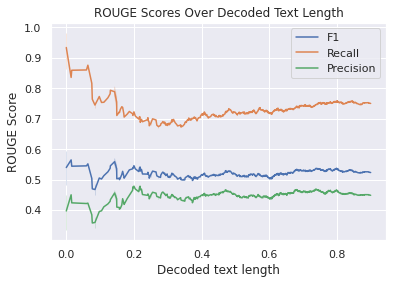

In [34]:
plt.title("ROUGE Scores Over Decoded Text Length")
plt.xlabel('Decoded text length')
plt.ylabel('ROUGE Score')

sns.lineplot(data=df, x='summary_size', y='s_F1', label='F1')
sns.lineplot(data=df, x='summary_size', y='s_Recall', label='Recall')
sns.lineplot(data=df, x='summary_size', y='s_Precision', label='Precision')
